# Plotting Notebook
This notebook displays and manipulates the histograms produced by `make_plots.py`. <br>
Please use this is a guide to the type plots that you can create, as examples of the `hist`, `mplhep`, and other packages, as well as the use of the various functions that we have written in `plot_utils.py`. <br>
Use the the Table of Contents in Jupyter to view the different sections of the notebook to help navigating it.

In [2]:
%load_ext autoreload

In [3]:
%autoreload 1

In [4]:
import os, sys, glob
import pickle
import math
import itertools
import warnings
import json
import numpy as np
from typing import Dict, List
from rich.pretty import pprint
from rich.console import Console
from rich.table import Table
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import hist
from hist import Hist
import mplhep as hep
from tabulate import tabulate
import scipy
%aimport plot_utils
%aimport fill_utils

warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams['figure.facecolor'] = 'white'
plt.style.use(hep.style.CMS)

In [5]:
print("The following output directories are available:")
!ls | grep output_histograms

The following output directories are available:
CR_cb_34mu_output_histograms
CR_cb_output_histograms
CR_prompt_34mu_leading_output_histograms
CR_prompt_34mu_output_histograms
CR_prompt_dimuon_output_histograms
CR_prompt_leading_output_histograms
CR_prompt_output_histograms
nbjet_comparison_output_histograms
temp_output_histograms


## Notebook Parameters
The following couple cells define the input and output directories, and load in the desired .pkl files into the `plots` nested dictionary.<br>
`output_label`: _str_, saves plots as `<output_label>+<plot_name>.<file_ext>`.<br>
`file_ext`: _str_, see above.<br>

In [6]:
# parameters
output_label = './output_plots/'
file_ext = '.png'

The `plots` dictionary is used to store all the plots imported from the pickle files. Dimensions: (sample) x (plot label) <br>
The `loader` function in `plot_utils.py` automatically merges all the QCD HT and QCD pT bins into one sample ('QCD_HT' and 'QCD_Pt'), applies the lumis, and excludes some of the low QCD bins.<br>

In [7]:
# create output dir
if not os.path.isdir(output_label): 
    print("Creating", output_label)
    os.mkdir(output_label)

# This part is meant to be flxeible, depending on what you want to import
# dimensions of plots: (sample) x (plot label)
# N.B.: lumis are applied through loader()

# input .pkl files
plotDir = './nbjet_comparison_output_histograms/'
infile_names = glob.glob(plotDir+'*.pkl')

# generate list of files that you want to merge histograms for
offline_files_SUEP = [
    f for f in infile_names if ("SUEP" in f) and ("histograms.pkl" in f)
]
offline_files_normalized = [
    f for f in infile_names if ("normalized.pkl" in f)
]
offline_files_other = [
    f for f in infile_names if ("pythia8" in f) and ("histograms.pkl" in f)
]
offline_files = offline_files_normalized + offline_files_other
pprint(offline_files)

data_files = [
    f for f in infile_names if ("DoubleMuon" in f) and ("histograms.pkl" in f)
]
pprint(data_files)

other_bkg_names = {
    "DYJetsToLL": "DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8",
    "DYLowMass_NLO": "DYJetsToLL_M-10to50_TuneCP5_13TeV-amcatnloFXFX-pythia8+"
                     "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "DYLowMass_LO": "DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8+"
                    "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM",
    "TTJets": "TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8+"
              "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "ttZJets": "ttZJets_TuneCP5_13TeV_madgraphMLM_pythia8+"
               "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "WWZ_4F": "WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8+"
              "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1_ext1-v2+MINIAODSIM",
    "ZZTo4L": "ZZTo4L_TuneCP5_13TeV_powheg_pythia8+"
              "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "ZZZ": "ZZZ_TuneCP5_13TeV-amcatnlo-pythia8+"
           "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1_ext1-v2+MINIAODSIM",
}

# merge the histograms, apply lumis, exclude low HT bins
plots_SUEP_2018 = plot_utils.loader(offline_files_SUEP, year=2018)
plots_2018 = plot_utils.loader(offline_files_normalized, year=2018)
plots_data = plot_utils.loader(data_files, year=2018, is_data=True)

# put everything in one dictionary, apply lumi for SUEPs
plots = {}
for key in plots_SUEP_2018.keys(): 
    plots[key+"_2018"] = fill_utils.apply_normalization(
        plots_SUEP_2018[key], 
        fill_utils.getXSection(key+'+RunIIAutumn18-private+MINIAODSIM', '2018', SUEP=True)
    )
for key in plots_2018.keys():
    is_binned = False
    binned_samples = [
        "QCD_Pt",
        "QCD_HT",
        "WZTo",
        "WZ_all",
        "JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8",
        "DYNJetsToLL",
    ]
    for binned_sample in binned_samples:
        if binned_sample in key:
            is_binned = True
    if is_binned and ('normalized' not in key) and ('cutflow' in key):
        continue
    if is_binned or ('bkg' in key):
        plots[key+"_2018"] = plots_2018[key]
    else:
        plots[key+"_2018"] = fill_utils.apply_normalization(
            plots_2018[key], 
            fill_utils.getXSection(other_bkg_names[key], '2018', SUEP=False)
        )

for key in plots_data.keys(): 
    plots[key+"_2018"] = plots_data[key]

[
│   './nbjet_comparison_output_histograms/QCD_HT1000to1500_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_HT100to200_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_HT1500to2000_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_HT2000toInf_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_HT200to300_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_HT300to500_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_HT500to700_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_HT50to100_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_HT700to1000_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_Pt_120to170_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_Pt_15to30_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_Pt_170to300_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_Pt_2400to3200_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_Pt_300to470_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_Pt_30to50_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_Pt_3200toInf_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_Pt_470to600_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './nbjet_comparison_output_histograms/QCD_Pt_50to80_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_real

[]

These are all the samples loaded.

In [8]:
keys = list(plots.keys())
pprint(keys)

[
│   'QCD_HT1000to1500_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_HT_2018',
│   'QCD_HT100to200_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_HT1500to2000_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_HT2000toInf_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_HT200to300_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_HT300to500_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_HT500to700_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_HT50to100_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_HT700to1000_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'bkg_2018',
│   'QCD_Pt_2018',
│   'QCD_Pt_120to170_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_15to30_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_170to300_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_2400to3200_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_300to470_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_30to50_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_3200toInf_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_470to600_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_50to80_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_600to800_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_800to1000_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_80to120_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized_2018'
]

In [9]:
for key in plots['QCD_Pt_2018'].keys():
    pprint(f"{key = }")

"key = 'ht'"

"key = 'nbjet'"

"key = 'ngenjet'"

## Show plots

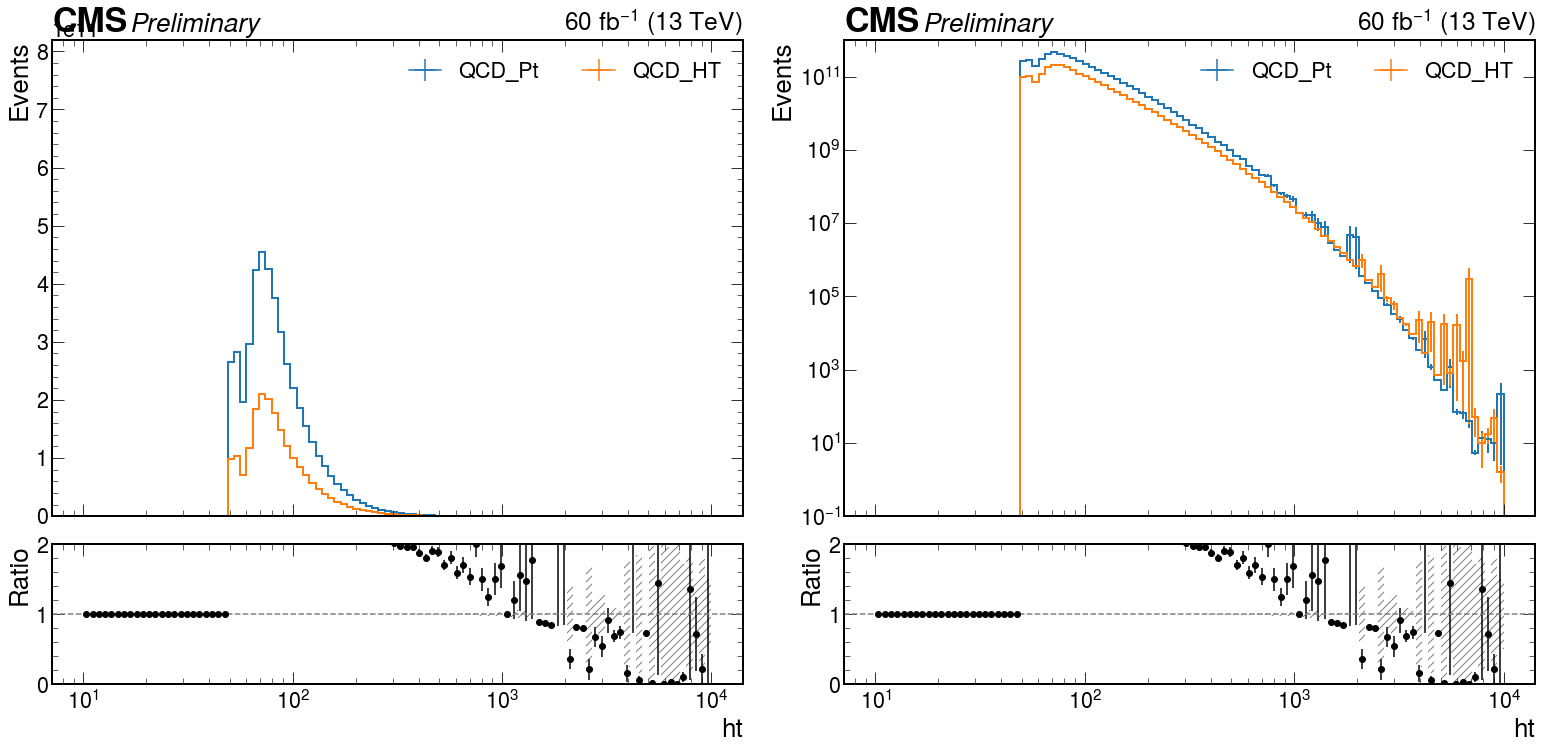

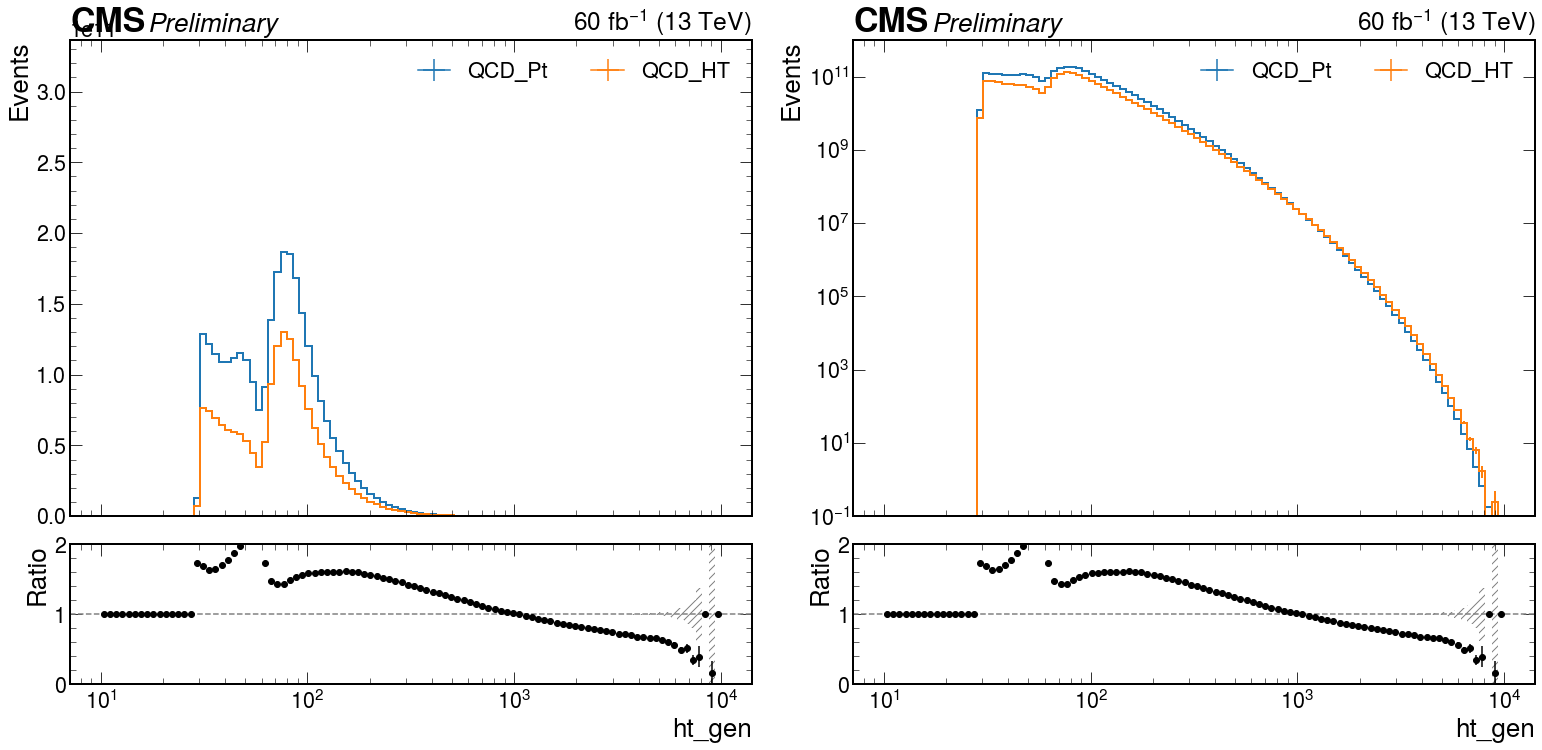

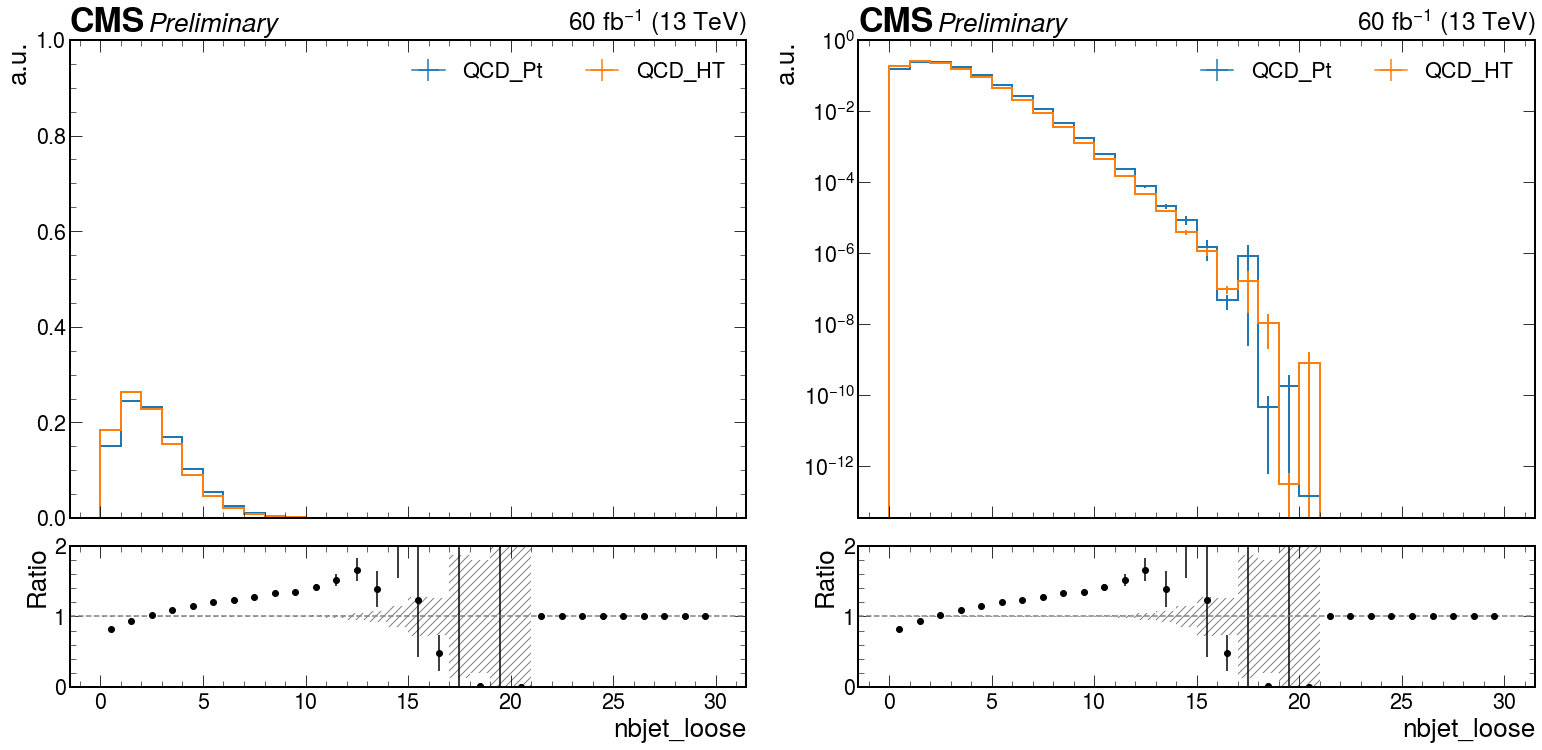

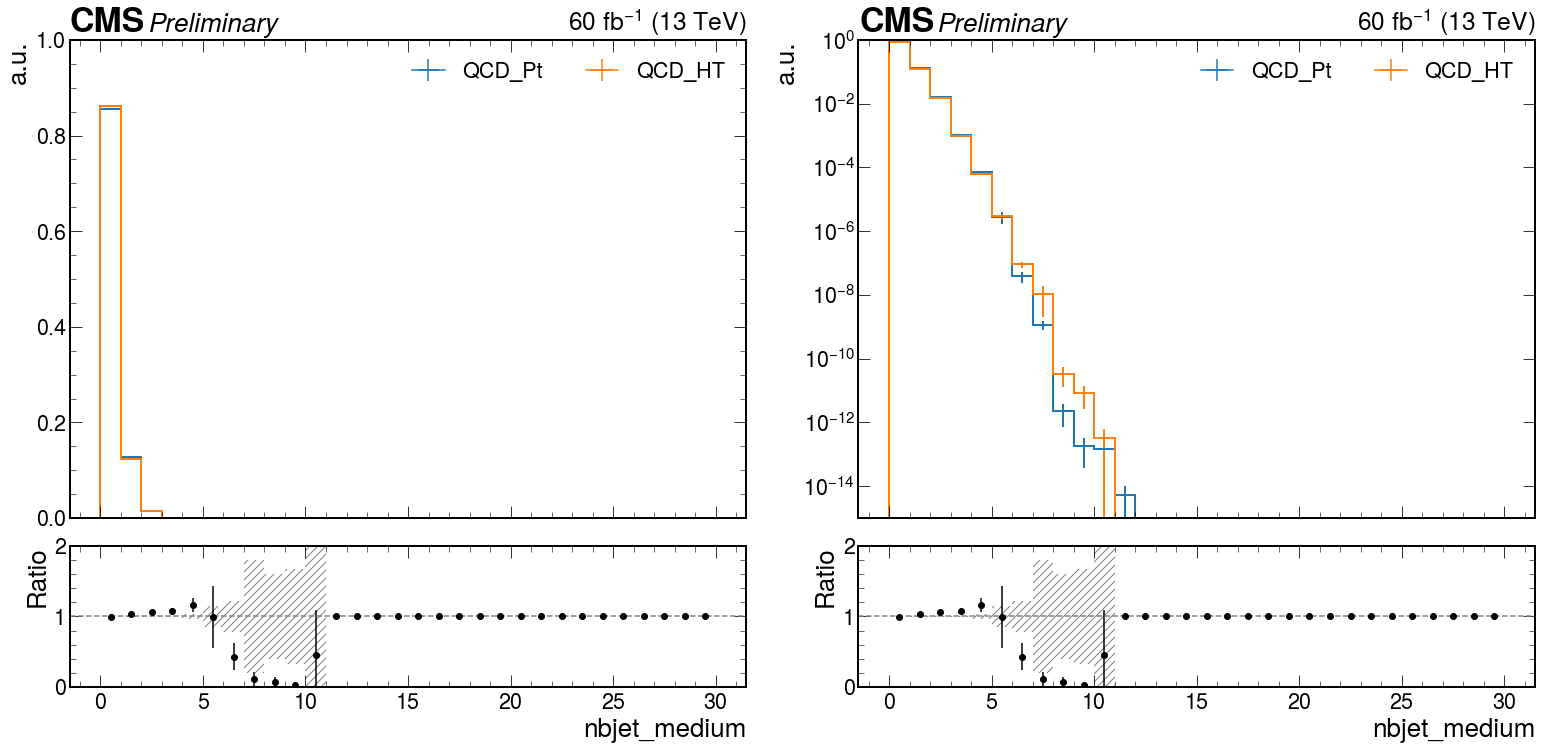

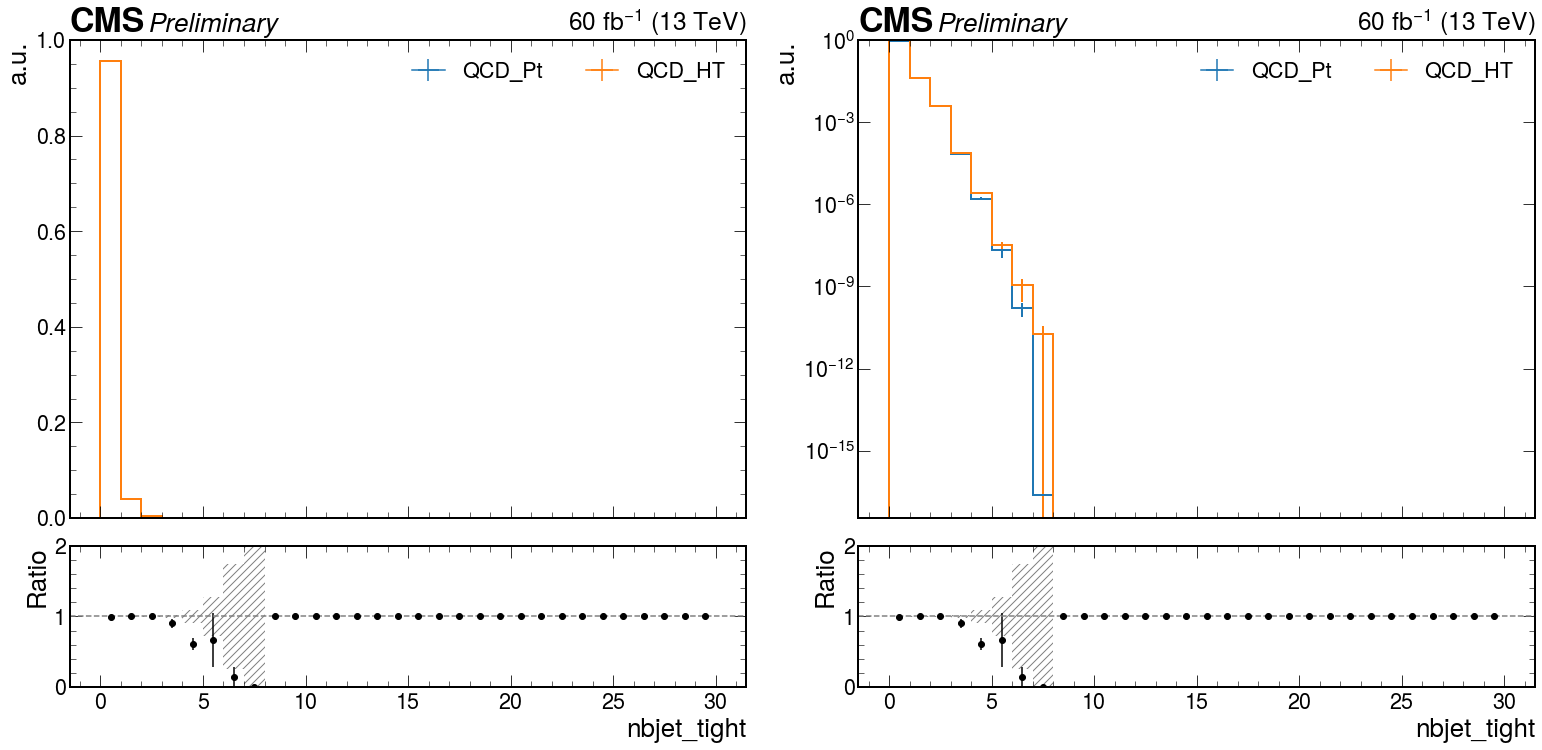

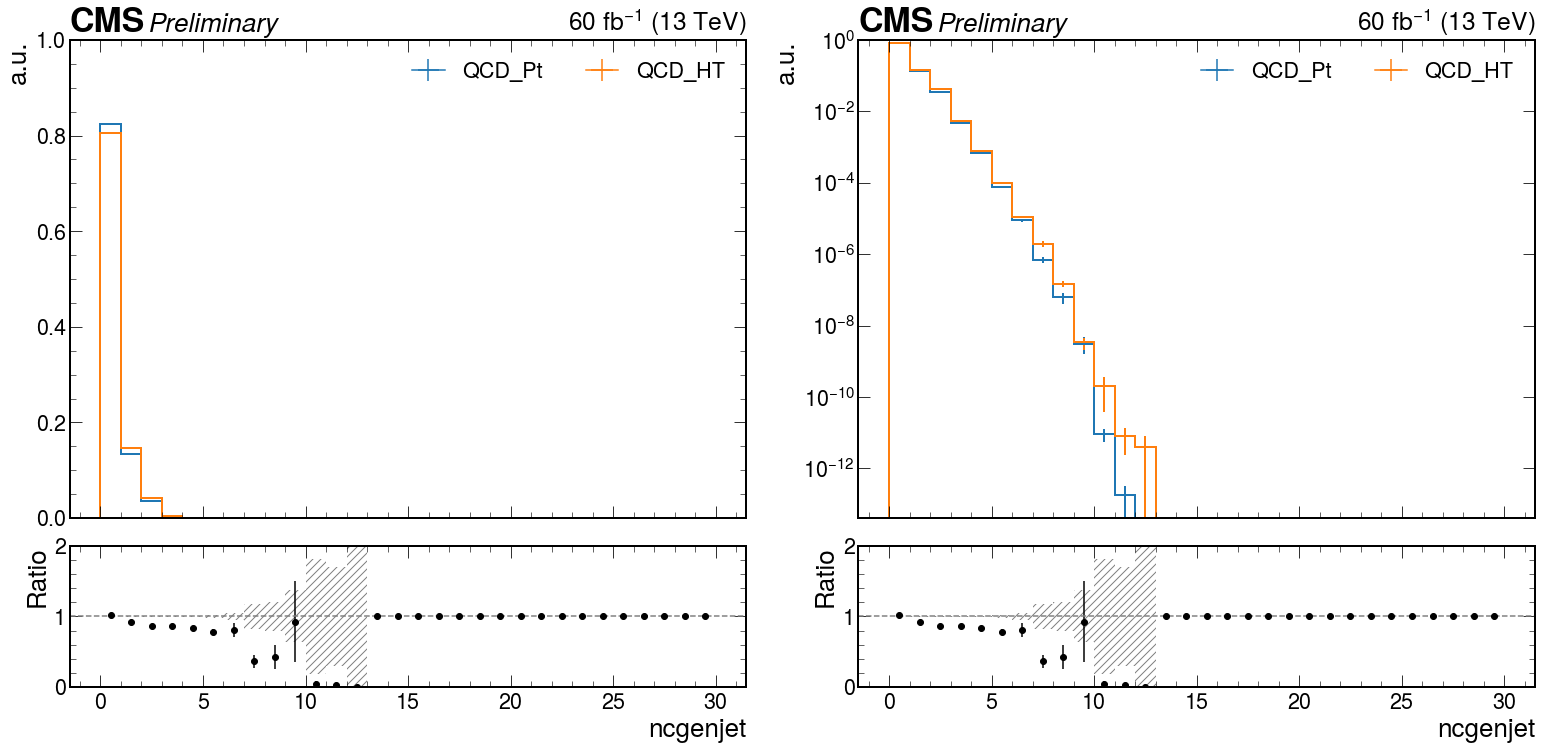

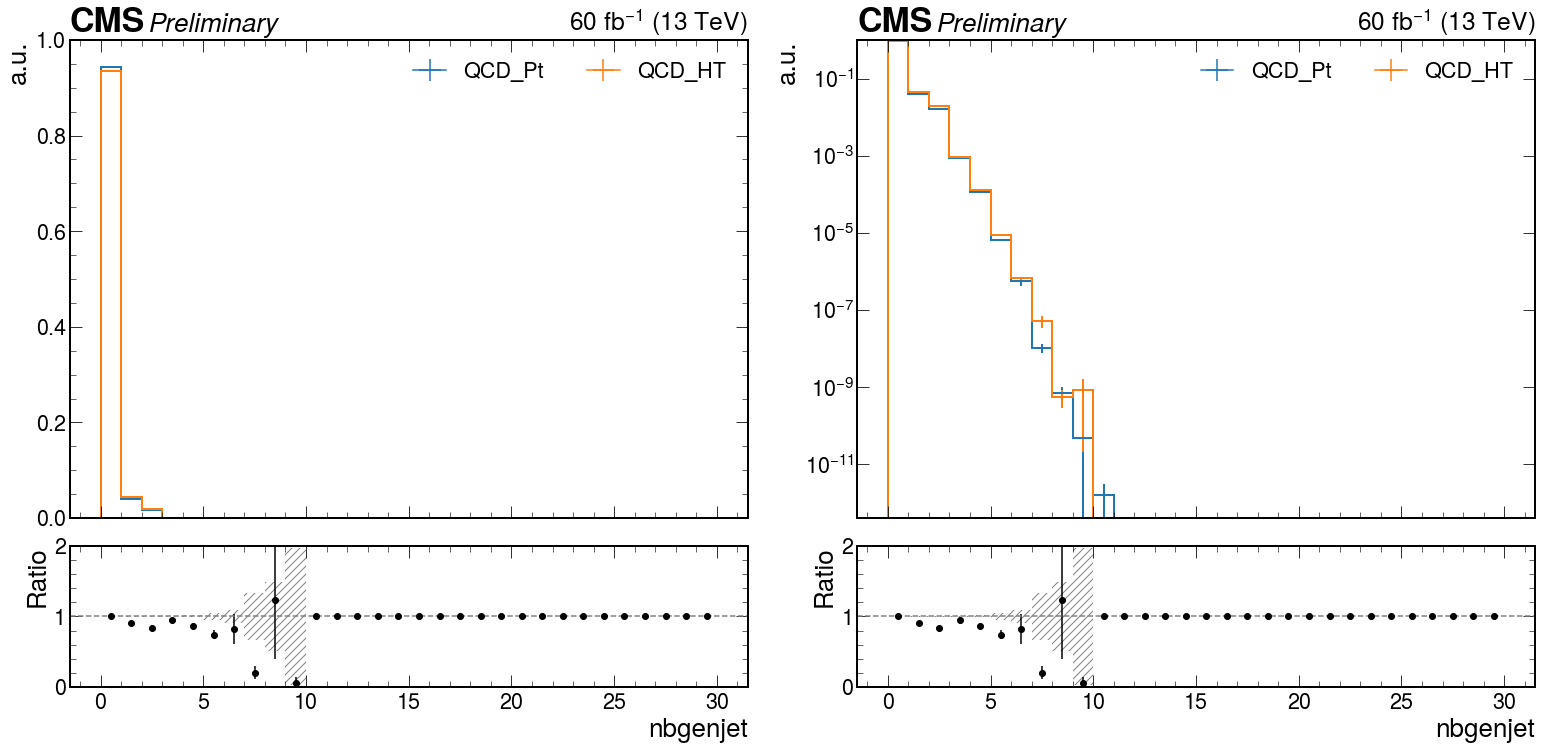

In [17]:
processes = [
    'QCD_Pt_2018',
    'QCD_HT_2018',
]

plot_set = [
    [
        ('ht','ht'),
        {
            'xlog': True
        }
    ],
    [
        ('ht','ht_gen'),
        {
            'xlog': True
        }
    ],
    [
        ('nbjet','nbjet_loose'),
        {'density': True}
    ],
    [
        ('nbjet','nbjet_medium'),
        {'density': True}
    ],
    [
        ('nbjet','nbjet_tight'),
        {'density': True}
    ],
    [
        ('ngenjet','ncgenjet'),
        {'density': True}
    ],
    [
        ('ngenjet','nbgenjet'),
        {'density': True}
    ],
]


for plot_i in plot_set:
    if plot_i[0][0] not in plots[processes[0]].keys():
        continue

    fig = plt.figure(figsize=(22, 11))
    G = gridspec.GridSpec(4, 2, figure=fig)
    left_gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=G[:, 0])
    right_gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=G[:, 1])
    plot_utils.plot_ratio_overlay(
        plots=plots, 
        hist_list=processes, 
        label=plot_i[0], 
        override_slice=True,
        fig=fig,
        gs=left_gs,
        per_muon=False,
        **plot_i[1]
    )
    plot_utils.plot_ratio_overlay(
        plots=plots, 
        hist_list=processes, 
        label=plot_i[0], 
        override_slice=True,
        fig=fig,
        gs=right_gs,
        ylog=True,
        per_muon=False,
        **plot_i[1]
    )
    plt.tight_layout()
    plt.show()